# Initial Data Exploration

This notebook analyzes data from various Helium Improvement Proposals (HIPs) on the Helium public server on Discord. The goal is to treat each HIP channel as a governance social network (GSN). Then, use Graph Neural Networks (GNNs) to predict if the a particular GSN predicts the outcome of the Governance vote on the HIP itself. 

In [50]:
# Imports
import json
import re
import networkx as nx
import hvplot.networkx as hvnxp
import pandas as pd
import holoviews as hv
import IPython
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [7]:
# Load json data
with open("hip77.json", "r", encoding="utf-8-sig") as read_file:
    data = json.load(read_file)

# Create a directed graph
G = nx.DiGraph()

for message in data["messages"]:
    user_id = message["author"]["id"]
    user_name = message["author"]["name"]
    user_color = message["author"]["color"]

    if user_id not in G.nodes:
        G.add_node(user_id, label=user_name, color=user_color, messages_sent=1)
    else:
        G.nodes[user_id]['messages_sent'] += 1

    for mention in message['mentions']:
        mentioned_id = mention['id']
        mentioned_name = mention['name']
        mentioned_color = mention['color']

        if mentioned_id not in G.nodes:
            G.add_node(mentioned_id, label=mentioned_name, color=mentioned_color, messages_sent=0)

        if (user_id, mentioned_id) not in G.edges:
            G.add_edge(user_id, mentioned_id, weight=1)
        else:
            G[user_id][mentioned_id]['weight'] += 1

In [8]:
# Plot initial graph
from pyvis.network import Network

net = Network(notebook=True, cdn_resources='remote')
net.from_nx(G)

# Now add color and label properties to nodes
for node in net.nodes:
    node["label"] = G.nodes[node["id"]]['label']
    node["color"] = G.nodes[node["id"]]['color']

net.show("hip77.html")

hip77.html


# Node & Edge Embeddings

## Information/Relation Extraction with BERT

For each author, we are going to gather all of their posts in the channel as a single string. Then, we will pass that string to BERT to create a fixed length vector embedding representing the semantic structure of that author's posts on the given topic in the HIP. This will be the basis for calculating the cosine similarity between two nodes, which will serve as one of the undirected edges between two nodes. This will represent some of the structure in the relationships between nodes. 

In [16]:
# Create a dictionary to store each author's messages
author_messages = {}

for message in data["messages"]:
    author_name = message["author"]["name"]
    content = message["content"]

    if author_name in author_messages:
        # Append the content to the existing string
        author_messages[author_name] += " " + content
    else:
        # Create a new string for this author
        author_messages[author_name] = content

In [29]:
# Print the result to verify
# Get a limited number of authors and only the first 50 chars of
# the message
count = 0
for author_id, messages in author_messages.items():
    if count < 2:
        print(f"Author Name: {author_id}")
        print(f"Messages: {messages[:50]}\n")
        count += 1
    else:
        break

Author Name: vincenzospaghetti
Messages: **HIP 77: Launch Parameters for Solana Migration**

Author Name: Siegfried
Messages: And the HIP assembly line keeps moving on 😀 .

Sma



In [30]:
# Import BERT
from transformers import BertTokenizer, BertModel

# Load pre-trained model tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model
model = BertModel.from_pretrained('bert-base-uncased')


C:\Users\sts45\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\sts45\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\huggingface_hub\file_download.py:129: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sts45\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.

In [33]:
author_embeddings = {}

for author_id, messages in author_messages.items():
    # Tokenize the messages
    inputs = tokenizer(messages, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    # Encode the messages
    outputs = model(**inputs)
    
    # Retrieve the embeddings (hidden states of the last layer)
    last_hidden_states = outputs.last_hidden_state
    
    # Obtain a sentence vector by mean pooling
    sentence_vector = last_hidden_states.mean(dim=1).detach().numpy()
    
    # Store the embeddings in the dictionary
    author_embeddings[author_id] = sentence_vector.reshape(-1)



In [40]:
len(author_embeddings["groot"])
author_embeddings["groot"][0:3]

array([-0.15342885, -0.06022774,  0.46629262], dtype=float32)

In [ ]:
# Apply PCA
embeddings = list(author_embeddings.values())

# Create a mapping from author name to color
author_name_to_color = {message["author"]["name"]: message["author"]["color"] 
                        for message in data["messages"]}
# Now map author names to colors
colors = [author_name_to_color[author] for author in author_embeddings.keys()]
# Replace None with a default color
colors = ['#000000' if color is None else color for color in colors]

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

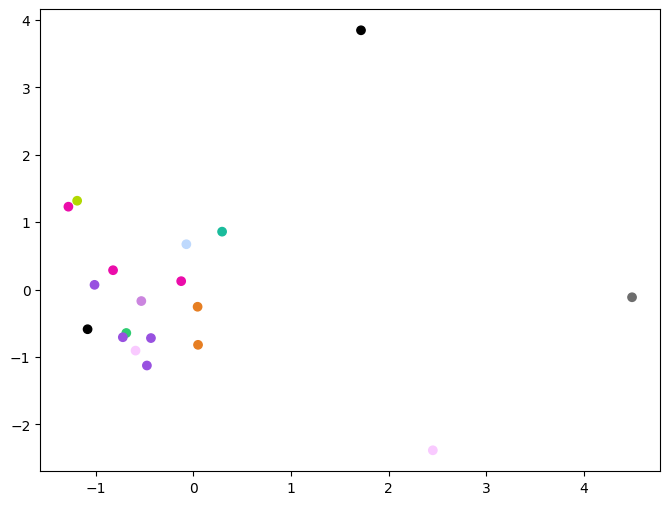

In [55]:
# Plot a scatterplot of the embedding space
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=colors)

plt.show()

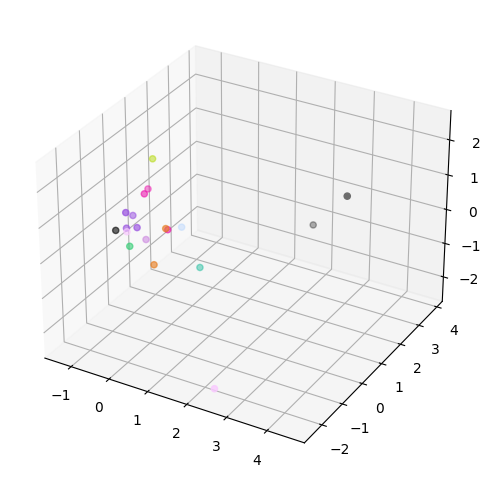

In [56]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embeddings)

# Replace None with a default color
colors = ['#000000' if color is None else color for color in colors]

# Plot a scatterplot of the embedding space
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings_3d[:,0], embeddings_3d[:,1], embeddings_3d[:,2], c=colors)

plt.show()


In [59]:
# List of author names
author_names = list(author_embeddings.keys())

# Create a trace for the 3D scatter plot
trace = go.Scatter3d(
    x=embeddings_3d[:,0], 
    y=embeddings_3d[:,1], 
    z=embeddings_3d[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=colors, 
    ),
    text=author_names,
    hoverinfo='text'
)

# Pack the trace into a data object
data = [trace]

# Create layout for the plot
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
        xaxis=dict(title='PC1'),
        yaxis=dict(title='PC2'),
        zaxis=dict(title='PC3'),
    )
)

# Create the plot
fig = go.Figure(data=data, layout=layout)
fig.show()

dict_keys(['vincenzospaghetti', 'Siegfried', 'WTV', 'hakeem', 'groot', 'Carl-bot', 'hashc0de', 'riobah', 'tchgeek', 'AndrewsMD', 'BuckGup', 'n_', 'gutentag', 'mgg57', 'anthonyra.eth', 'ferebee', 'Tushar', 'mcharliem', 'KeithR'])


## Link Creation

# Preparing for GNN